In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('..')

from src.model import DeepCleanAutoencoder
from src.dataset import GWDataset
from src.utils import postprocess

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

Running on device: cuda


### Config

In [20]:
MODEL_PATH = '../models/best_model.pth'
TEST_DATA_PATH = '../data/test_data.npz' 

# match training
LINEAR = False
SAMPLE_RATE = 4096
BAND_MIN = 55
BAND_MAX = 900
INFERENCE_OVERLAP = 4.0

### Load Data and Model

In [21]:
data = np.load(TEST_DATA_PATH)
strain_raw = data['strain']
witnesses_raw = data['witnesses']

print(f"Strain Shape: {strain_raw.shape}")
print(f"Witnesses Shape: {witnesses_raw.shape}")

test_dataset = GWDataset(
    strain_raw, 
    witnesses_raw, 
    SAMPLE_RATE, 
    overlap=INFERENCE_OVERLAP, 
    band_start=BAND_MIN, 
    band_end=BAND_MAX,
    linear=LINEAR
)

model = DeepCleanAutoencoder(num_witnesses=witnesses_raw.shape[0]).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded")

Strain Shape: (4194304,)
Witnesses Shape: (5, 4194304)
Model loaded


In [22]:
for key in data.keys():
    print(key)
    print(data[key])

strain
[-8.75331223e-20 -6.50758007e-20 -1.47184001e-19 ...
 -6.68859193e-19 -6.63851330e-19 -6.37460630e-19]
witnesses
[[ 3.08672810e+01  3.44549637e+01  3.82058563e+01 ...
   3.83053541e+00  1.62563515e+01  2.52936554e+01]
 [-1.11689995e+02 -1.13331619e+02 -1.18509430e+02 ...
  -9.73372803e+01 -1.07772110e+02 -1.11254562e+02]
 [-6.81328354e+01 -8.01825638e+01 -8.74759979e+01 ...
  -4.23530006e+01 -5.04486771e+01 -5.75333595e+01]
 [-1.85706024e+01 -1.86819439e+01 -1.87873669e+01 ...
  -1.86293945e+01 -1.85790195e+01 -1.85361176e+01]
 [-1.03218852e-03  1.14374050e-01  2.20349398e-01 ...
   8.58997365e-01  8.70830222e-01  9.06812775e-01]]
times
[1.18674056e+09 1.18674056e+09 1.18674056e+09 ... 1.18674159e+09
 1.18674159e+09 1.18674159e+09]
sample_rate
4096
gps_start
1186740564
duration
1024
detector
H1
witness_channels
['H1:PEM-CS_ACC_PSL_TABLE1_X_DQ' 'H1:PEM-CS_ACC_PSL_TABLE1_Y_DQ'
 'H1:PEM-CS_ACC_PSL_TABLE1_Z_DQ' 'H1:PEM-CS_ACC_PSL_TABLE2_Z_DQ']


### Run Inference + post process stuff

In [23]:
import numpy as np
import torch

# Choose a smooth window for overlap-add (Hann)
window = np.hanning(test_dataset.seg_len)

# Preallocate output arrays
total_len = len(strain_raw)
reconstructed = np.zeros(total_len)
weight_sum = np.zeros(total_len)

for segment_idx in range(len(test_dataset)):
    w_tensor, h_tensor_norm = test_dataset[segment_idx]
    w_batch = w_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_normalized = model(w_batch)

    noise_estimate = postprocess(
        pred_normalized,
        test_dataset.strain_mean,
        test_dataset.strain_std,
        SAMPLE_RATE,
        BAND_MIN,
        BAND_MAX,
    )

    # Original segment
    start_idx = test_dataset.indices[segment_idx]
    end_idx = start_idx + test_dataset.seg_len
    segment_original = strain_raw[start_idx:end_idx]

    # Cleaned segment
    segment_cleaned = segment_original - noise_estimate

    # Apply Hann window
    windowed_cleaned = segment_cleaned * window

    # Overlap-add
    reconstructed[start_idx:end_idx] += windowed_cleaned
    weight_sum[start_idx:end_idx] += window

# Normalize to account for overlapping weights
nonzero = weight_sum > 0
reconstructed[nonzero] /= weight_sum[nonzero]

print("Reconstruction complete using dataset segment lengths and overlaps.")

Reconstruction complete using dataset segment lengths and overlaps.


<Figure size 2800x1400 with 0 Axes>

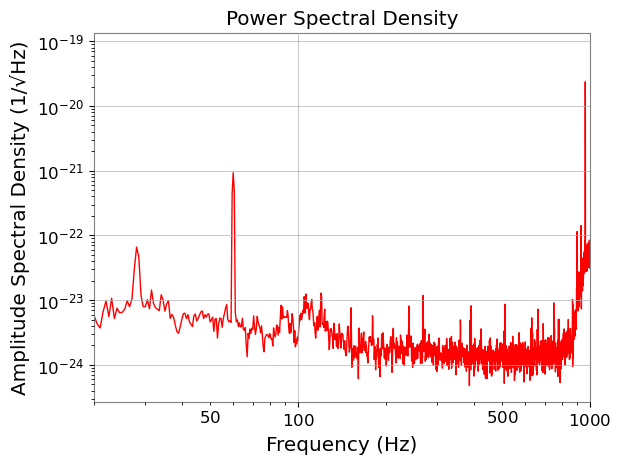

<Figure size 2800x1400 with 0 Axes>

In [24]:
from gwpy.timeseries import TimeSeries

aaaa = TimeSeries(noise_estimate, unit = 's', t0 = 0, dt = 1 / 4096)
# 3. Power Spectral Density (PSD)
psd = aaaa.psd(fftlength=2, overlap=1)
plt.loglog(psd.frequencies.value, np.sqrt(psd.value), 'r-', linewidth=1, label='Original Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectral Density (1/√Hz)')
plt.title('Power Spectral Density')
plt.xlim(20, 1000)
#axes.set_ylim(ymin, ymax)
plt.figure(figsize=(28, 14))


### Actual visualization stuff i dont feel like doing

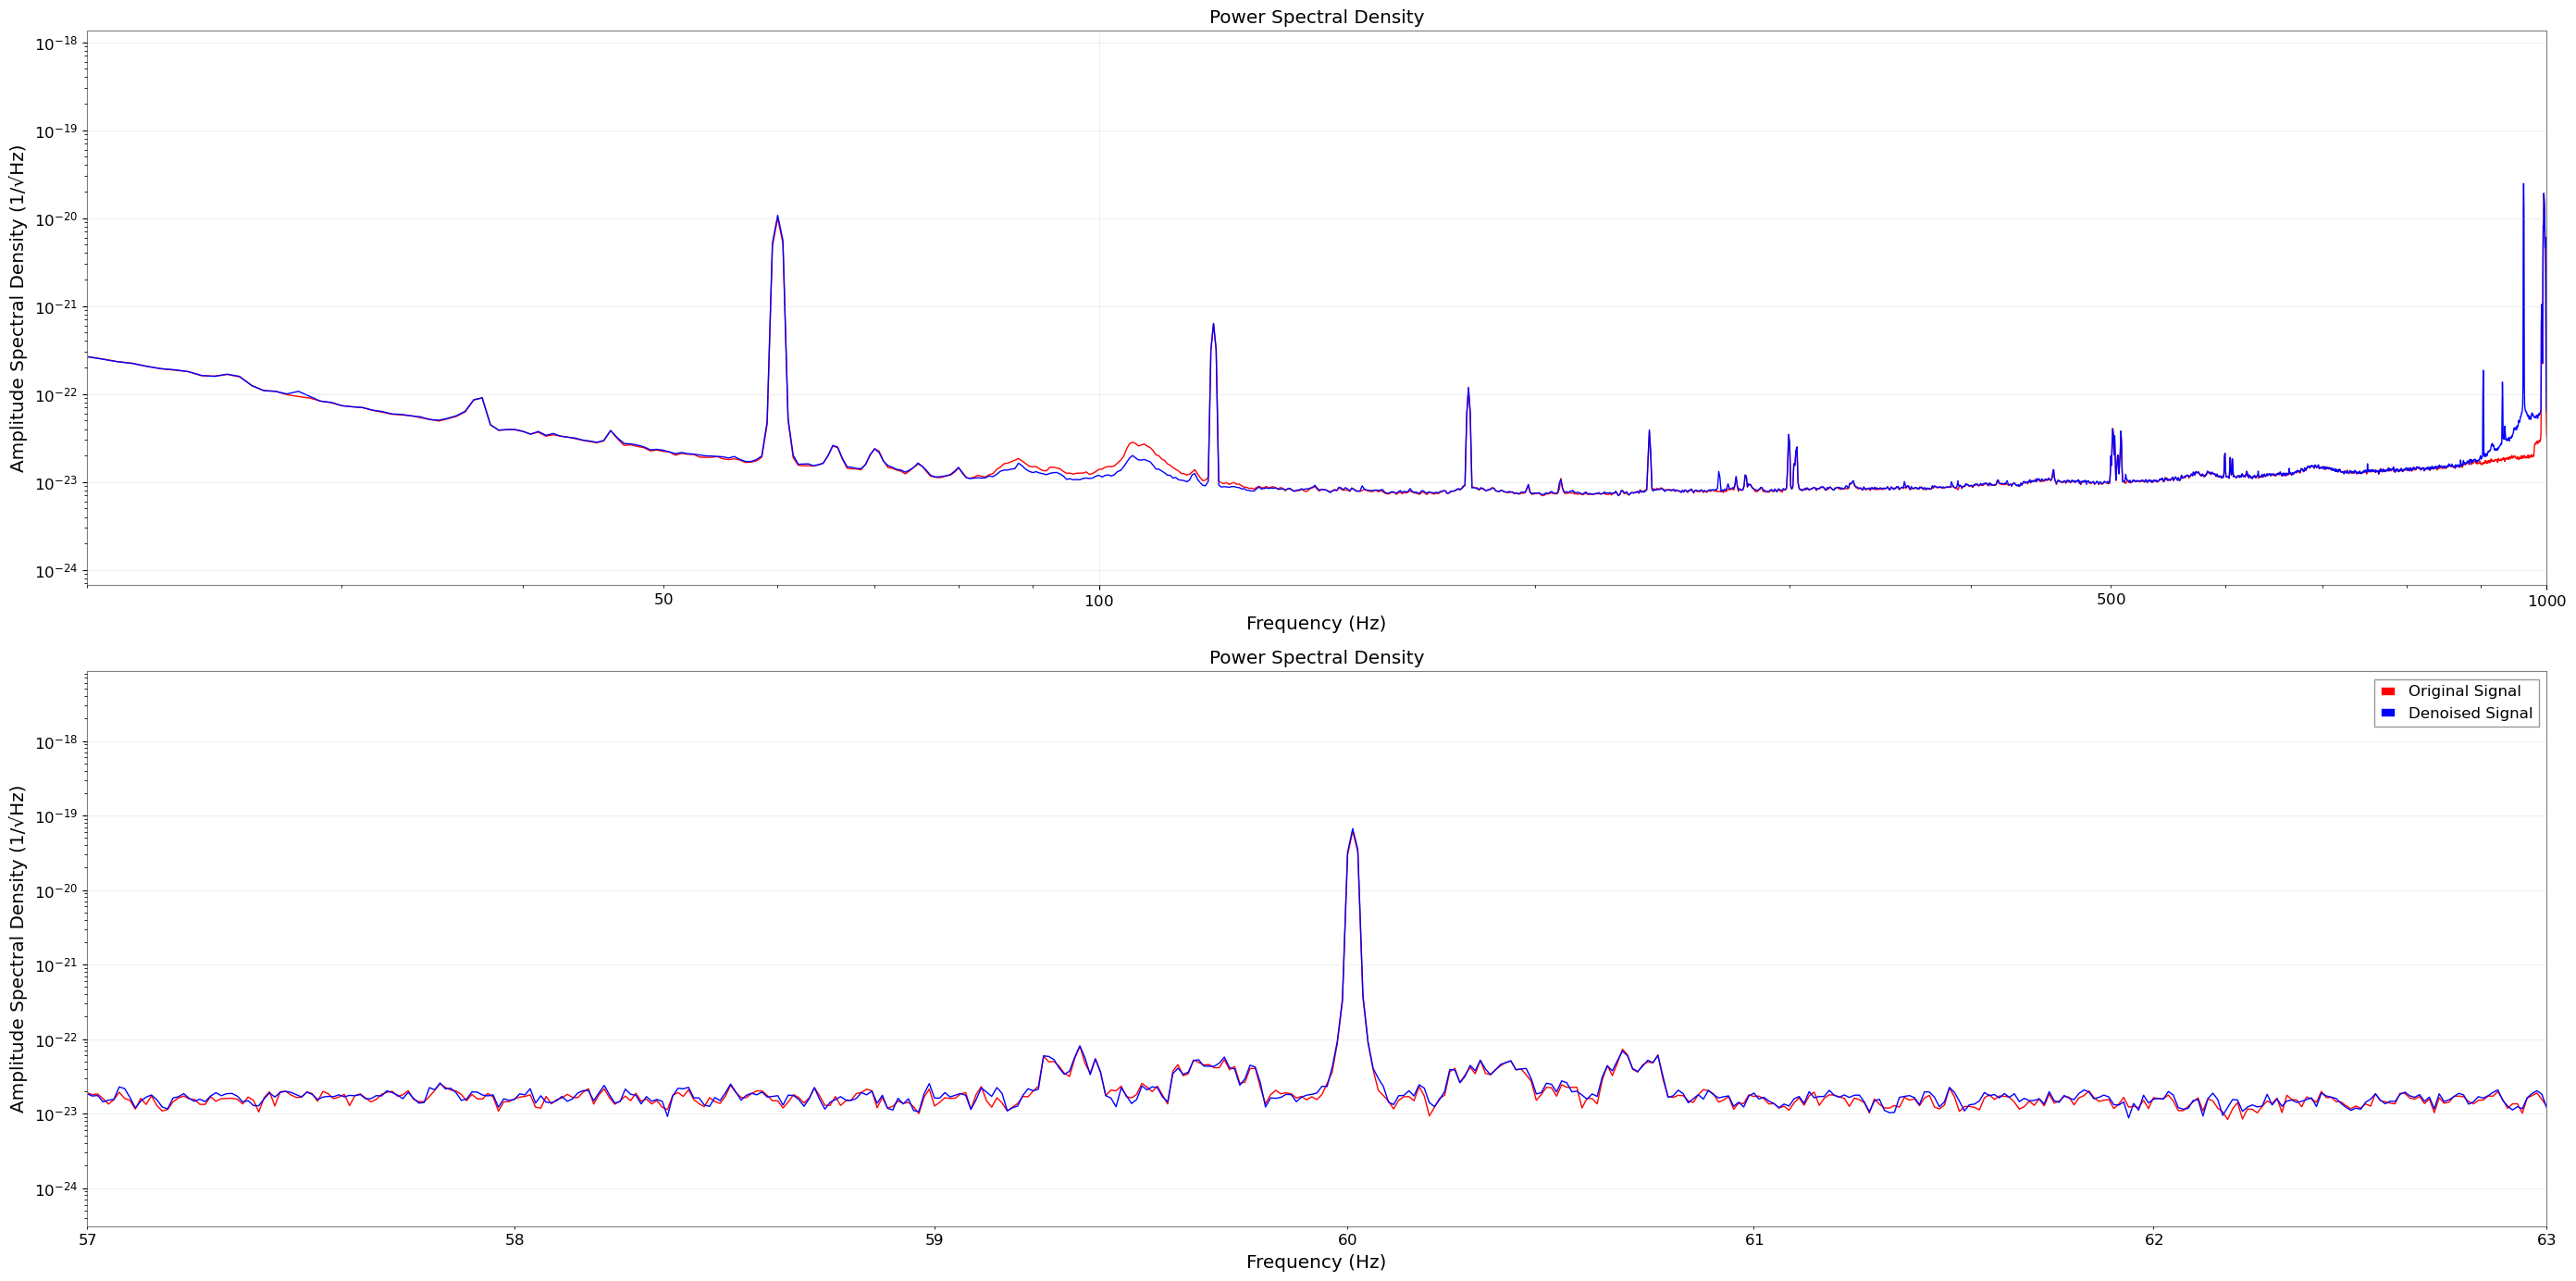

In [25]:
from src.utils import visualize_data
def visualize_data_compare(data, denoisedData):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 1, figsize=(14*2, 14))

    # 3. Power Spectral Density (PSD)
    psd = data.psd(fftlength=2, overlap=1)
    axes[0].loglog(psd.frequencies.value, np.sqrt(psd.value), 'r-', linewidth=1, label='Original Signal')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[0].set_title('Power Spectral Density')
    axes[0].set_xlim(20, 1000)
    #axes.set_ylim(ymin, ymax)
    axes[0].grid(True, alpha=0.3)

    psd = data.psd(fftlength=80, overlap=20)
    axes[1].loglog(psd.frequencies.value, np.sqrt(psd.value), 'r-', linewidth=1, label='Original Signal')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[1].set_title('Power Spectral Density')
    axes[1].set_xlim(57, 63)
    #axes.set_ylim(ymin, ymax)
    axes[1].grid(True, alpha=0.3)

    # 3. Power Spectral Density (PSD)
    psd = denoisedData.psd(fftlength=2, overlap=1)
    axes[0].loglog(psd.frequencies.value, np.sqrt(psd.value), 'b-', linewidth=1, label='Denoised Signal')
    axes[0].set_xlabel('Frequency (Hz)')
    axes[0].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[0].set_title('Power Spectral Density')
    axes[0].set_xlim(20, 1000)
    #axes.set_ylim(ymin, ymax)
    axes[0].grid(True, alpha=0.3)

    psd = denoisedData.psd(fftlength=80, overlap=20)
    axes[1].loglog(psd.frequencies.value, np.sqrt(psd.value), 'b-', linewidth=1, label='Denoised Signal')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[1].set_title('Power Spectral Density')
    axes[1].set_xlim(57, 63)
    #axes.set_ylim(ymin, ymax)
    axes[1].grid(True, alpha=0.3)

    plt.legend()

    plt.tight_layout()
    plt.show()

dataOriginal = TimeSeries(strain_raw, unit='s', dt = 1/ 4096)
denoisedData = TimeSeries(reconstructed, unit = 's', t0 = 0, dt = 1 / 4096)
visualize_data_compare(dataOriginal, denoisedData)

In [ ]:
dataTS = TimeSeries(strain_raw, unit = 's', t0 = 0, dt = 1 / 4096)
visualize_data(dataTS)

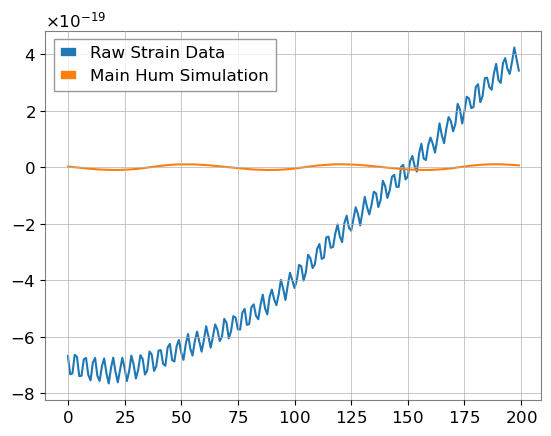

In [17]:
k = 100
plt.plot(strain_raw[k: k + 200], label='Noised Strain Data')
plt.plot(witnesses_raw[-1][k: k + 200] * 1e-20, label = 'Main Hum Simulation')
plt.legend()
plt.show()

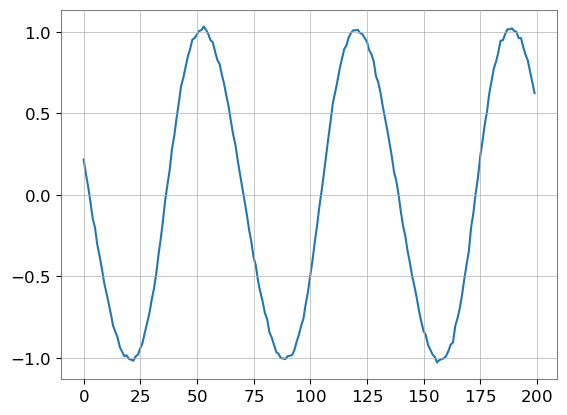

In [14]:
k = 100
